## Lesson 8 - Text pre processing, jieba, TF-IDF




### Table of Contents

* [Bayes Classification](#BayesClassification)
* [jieba中文斷詞](#中文斷詞)
* [文句處理，詞袋 Bag of Words、N-gram以及TFIDF模型](#text-processing-models)
* [話題型模型分類](#TopicModels)
* [利用Bayes分類法做中文分類器](#Naive-Bayes-Classifier-Chinese)

The previous four sections have given a general overview of the concepts of machine learning.
In this section and the ones that follow, we will be taking a closer look at several specific algorithms for supervised and unsupervised learning, starting here with naive Bayes classification.

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets.
Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem.
This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

<div>
    <img src="images/NaiveBayes.png" width="400">
    <center>Copyright & Disclaimer: All Pictures shown are for illustration purpose only</center>
</div>

<a id="BayesClassification"></a>
## Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods.
These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities.
In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label.
Such a model is called a *generative model* because it specifies the hypothetical random process that generates the data.
Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier.
The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification.
Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

We begin with the standard imports:

## Convert list of dictionaries to a pandas DataFrame

![title](images/creditcard.png)

In [1]:
import pandas as pd

samples = []
samples.append({"年齡":"<21", "性別":"男", "職業":"學生", "月收入":"低", "辦卡":"不會"})
samples.append({"年齡":"21~30", "性別":"女", "職業":"學生", "月收入":"低", "辦卡":"會"})
samples.append({"年齡":"21~30", "性別":"男", "職業":"上班族", "月收入":"低", "辦卡":"會"})
samples.append({"年齡":">41", "性別":"男", "職業":"上班族", "月收入":"高", "辦卡":"會"})
samples.append({"年齡":"31~40", "性別":"男", "職業":"待業", "月收入":"低", "辦卡":"不會"})
samples.append({"年齡":"31~40", "性別":"男", "職業":"上班族", "月收入":"中", "辦卡":"不會"})
samples.append({"年齡":"31~40", "性別":"女", "職業":"待業", "月收入":"低", "辦卡":"會"})
samples.append({"年齡":"31~40", "性別":"女", "職業":"上班族", "月收入":"中", "辦卡":"會"})
samples.append({"年齡":"31~40", "性別":"女", "職業":"上班族", "月收入":"高", "辦卡":"不會"})
samples.append({"年齡":"<21", "性別":"女", "職業":"學生", "月收入":"低", "辦卡":"會"})
df = pd.DataFrame(samples)
df

,年齡,性別,月收入,職業,辦卡
0,<21,男,低,學生,不會
1,21~30,女,低,學生,會
2,21~30,男,低,上班族,會
3,>41,男,高,上班族,會
4,31~40,男,低,待業,不會
5,31~40,男,中,上班族,不會
6,31~40,女,低,待業,會
7,31~40,女,中,上班族,會
8,31~40,女,高,上班族,不會
9,<21,女,低,學生,會


$$P(男生)$$

In [2]:
df[df["性別"]=='男']

,年齡,性別,月收入,職業,辦卡
0,<21,男,低,學生,不會
2,21~30,男,低,上班族,會
3,>41,男,高,上班族,會
4,31~40,男,低,待業,不會
5,31~40,男,中,上班族,不會


$$P(女生)$$

In [3]:
df[df["性別"]=='女']

,年齡,性別,月收入,職業,辦卡
1,21~30,女,低,學生,會
6,31~40,女,低,待業,會
7,31~40,女,中,上班族,會
8,31~40,女,高,上班族,不會
9,<21,女,低,學生,會


$$P(男生 \mid 會辦卡)$$

In [4]:
df[(df["性別"]=='男') & (df["辦卡"]=='會')]

,年齡,性別,月收入,職業,辦卡
2,21~30,男,低,上班族,會
3,>41,男,高,上班族,會


$$P(女生 \mid 會辦卡)$$

In [5]:
df[(df["性別"]=='女') & (df["辦卡"]=='會')]

,年齡,性別,月收入,職業,辦卡
1,21~30,女,低,學生,會
6,31~40,女,低,待業,會
7,31~40,女,中,上班族,會
9,<21,女,低,學生,會


## 資料視覺化

In [6]:
import seaborn as sns
import numpy as np
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\kaiu.ttf',size=14)
sns.set(font=myfont.get_name())

%matplotlib inline

In [7]:
#To do the boxplot on entiredataframe
try:
    sns.boxplot(x='性別', y='辦卡', data=df, palette='rainbow')
except Exception as e:
    # 字串無法拿來繪圖或統計
    print("Exception :{}".format(str(e)))

df['辦卡(0/1)'] = np.where(df['辦卡'] == '會', 1, 0)
df.head()

Exception :Neither the `x` nor `y` variable appears to be numeric.


,年齡,性別,月收入,職業,辦卡,辦卡(0/1)
0,<21,男,低,學生,不會,0
1,21~30,女,低,學生,會,1
2,21~30,男,低,上班族,會,1
3,>41,男,高,上班族,會,1
4,31~40,男,低,待業,不會,0


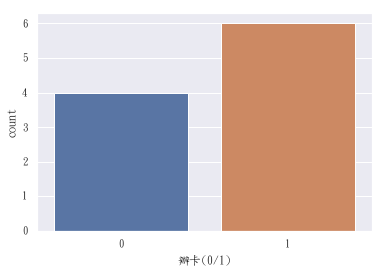

In [8]:
# 資料集中辦卡與未辦卡的統計
sns.countplot(x='辦卡(0/1)', data=df)

In [9]:
# sns.boxplot(x='性別', y='辦卡(0/1)', data=df, palette='rainbow')

### 機率
#### 先來看一個銀行信用卡的會員資料庫例子，若要判斷新進人口樣本A「女性、年齡介於31~40之間、上班族、月收入中等者」，會不會辦信用卡?

```
首先根據這10筆訓練樣本資料求不同分類結果的條件機率：
P(會)P(女|會)P(31~40|會)P(上班|會)P(中|會)
```

$$P(會辦卡)P(女生 \mid 會辦卡)P(31~40歲 \mid 會辦卡)P(上班族 \mid 會辦卡)P(中等收入 \mid 會辦卡)$$
<a id="bayes"></a>
### 貝氏定理 (Bayes' theorem)
$$P(A \mid B) = \frac{ P(B \mid A) P(A) }{ P(B) }$$

i.g.: 會辦卡的女生
    
$$P(女生 \mid 會辦卡) = \frac{ P(會辦卡 \mid 女生) P(女生) }{ P(會辦卡) }$$

In [10]:
# p(會辦卡)
a = len(df[df["辦卡"]=='會']) # 會辦卡 = 6 人
b = len(df)                  # 所有人 = 10 人
# 所有人會辦卡的機率
p1 = a/b

# p(女生|會辦卡)
a = len(df[(df["性別"]=='女') & (df["辦卡"]=='會')]) # 會辦卡中女生的人數 = 4 人
b = len(df[df["辦卡"]=='會'])                       # 所有人中會辦卡的有 = 6 人
p2 = a/b

# p(31~40歲|會辦卡)
a = len(df[(df["年齡"]=='31~40') & (df["辦卡"]=='會')]) # 會辦卡中年齡落在31~40歲 = 2人
b = len(df[df["辦卡"]=='會'])                          # 所有人中會辦卡的有 = 6 人
p3 = a/b

# p(上班族|會辦卡)
a = len(df[(df["職業"]=='上班族') & (df["辦卡"]=='會')]) # 會辦卡中上班族 = 3人
b = len(df[df["辦卡"]=='會'])                           # 所有人中會辦卡的有 = 6 人
p4 = a/b

# p(中等收入|會辦卡)
a = len(df[(df["月收入"]=='中') & (df["辦卡"]=='會')]) # 會辦卡中上班族 = 1人
b = len(df[df["辦卡"]=='會'])                         # 所有人中會辦卡的有 = 6 人
p5 = a/b
p5

p = p1 * p2 * p3 * p4 *p5
print("女性、年齡介於31~40之間、上班族、月收入中等者辦信用卡的機率 = {}".format(p))

女性、年齡介於31~40之間、上班族、月收入中等者辦信用卡的機率 = 0.011111111111111108


$$\frac{6}{10} × \frac{4}{6} × \frac{2}{6} × \frac{3}{6} × \frac{1}{6} = \frac{1}{90} = 0.0111$$

## 隨堂練習
#### 女性、年齡介於31~40之間、上班族、月收入中等者，不會辦信用卡的機率?
Hint: P(不會)P(女|不會)P(31~40|不會)P(上班|不會)P(中|不會)

In [11]:
#解答：
# p(會辦卡)
a = len(df[df["辦卡"]=='不會']) # 會辦卡 = 6 人
b = len(df)                  # 所有人 = 10 人
# 所有人不會辦卡的機率
p1 = a/b

# p(女生|會辦卡)
a = len(df[(df["性別"]=='女') & (df["辦卡"]=='不會')]) # 會辦卡中女生的人數 = 4 人
b = len(df[df["辦卡"]=='不會'])                       # 所有人中會辦卡的有 = 6 人
p2 = a/b

# p(31~40歲|會辦卡)
a = len(df[(df["年齡"]=='31~40') & (df["辦卡"]=='不會')]) # 會辦卡中年齡落在31~40歲 = 2人
b = len(df[df["辦卡"]=='不會'])                          # 所有人中會辦卡的有 = 6 人
p3 = a/b

# p(上班族|會辦卡)
a = len(df[(df["職業"]=='上班族') & (df["辦卡"]=='不會')]) # 會辦卡中上班族 = 3人
b = len(df[df["辦卡"]=='不會'])                           # 所有人中會辦卡的有 = 6 人
p4 = a/b

# p(中等收入|會辦卡)
a = len(df[(df["月收入"]=='中') & (df["辦卡"]=='不會')]) # 會辦卡中上班族 = 1人
b = len(df[df["辦卡"]=='不會'])                         # 所有人中會辦卡的有 = 6 人
p5 = a/b

p = p1 * p2 * p3 * p4 * p5
print("女性、年齡介於31~40之間、上班族、月收入中等者，不會辦信用卡的機率 = {}".format(p))

女性、年齡介於31~40之間、上班族、月收入中等者，不會辦信用卡的機率 = 0.009375000000000001


$$\frac{4}{10} × \frac{1}{4} × \frac{3}{4} × \frac{2}{4} × \frac{1}{4} = \frac{24}{2560} = 0.009375$$

### 結論
就統計的角度來看，依此資料集，「會辦卡」的機率為0.0111，大於「不會辦卡」的機率0.009375，所以樸素貝氏分類預測新進樣本A會辦卡機率較大。

## function of prediction

In [12]:
def predict_apply_credit_card(gender, age, job, salary, apply):
    a = len(df[df["辦卡"]==apply])
    b = len(df)
    p1 = a/b

    a = len(df[(df["性別"]==gender) & (df["辦卡"]==apply)])
    b = len(df[df["辦卡"]==apply])
    p2 = a/b

    a = len(df[(df["年齡"]==age) & (df["辦卡"]==apply)])
    b = len(df[df["辦卡"]==apply])
    p3 = a/b

    a = len(df[(df["職業"]==job) & (df["辦卡"]==apply)])
    b = len(df[df["辦卡"]==apply])
    p4 = a/b

    a = len(df[(df["月收入"]==salary) & (df["辦卡"]==apply)])
    b = len(df[df["辦卡"]==apply])
    p5 = a/b

    p = p1 * p2 * p3 * p4 * p5
    return p

In [13]:
p = predict_apply_credit_card("女", "31~40", "上班族", "中", "不會")
print("女性、年齡介於31~40之間、上班族、月收入中等者，不會辦信用卡的機率 = {}".format(p))

女性、年齡介於31~40之間、上班族、月收入中等者，不會辦信用卡的機率 = 0.009375000000000001


## given all the permutations and combinations

In [14]:
gender = ['男','女']
age = ['<21', '21~30', '31~40', '>41']
job = ['學生', '上班族', '待業']
salary = ['低', '中', '高']
apply = ['會', '不會']
res = []
for g in gender:
    for a in age:
        for j in job:
            for s in salary:
                p = predict_apply_credit_card(g, a, j, s, "會")
                res.append( {"combinations": "{} {} {} {}".format(g,a,j,s), "probability": p} )

In [15]:
res

[{'combinations': '男 <21 學生 低', 'probability': 0.007407407407407405},
 {'combinations': '男 <21 學生 中', 'probability': 0.0018518518518518513},
 {'combinations': '男 <21 學生 高', 'probability': 0.0018518518518518513},
 {'combinations': '男 <21 上班族 低', 'probability': 0.011111111111111108},
 {'combinations': '男 <21 上班族 中', 'probability': 0.002777777777777777},
 {'combinations': '男 <21 上班族 高', 'probability': 0.002777777777777777},
 {'combinations': '男 <21 待業 低', 'probability': 0.0037037037037037025},
 {'combinations': '男 <21 待業 中', 'probability': 0.0009259259259259256},
 {'combinations': '男 <21 待業 高', 'probability': 0.0009259259259259256},
 {'combinations': '男 21~30 學生 低', 'probability': 0.01481481481481481},
 {'combinations': '男 21~30 學生 中', 'probability': 0.0037037037037037025},
 {'combinations': '男 21~30 學生 高', 'probability': 0.0037037037037037025},
 {'combinations': '男 21~30 上班族 低', 'probability': 0.022222222222222216},
 {'combinations': '男 21~30 上班族 中', 'probability': 0.005555555555555554},

In [16]:
# 將 list 轉成DataFrame
dfp = pd.DataFrame(res)
dfp.head()

,combinations,probability
0,男 <21 學生 低,0.007407
1,男 <21 學生 中,0.001852
2,男 <21 學生 高,0.001852
3,男 <21 上班族 低,0.011111
4,男 <21 上班族 中,0.002778


In [17]:
# 選擇最高可能辦卡的組合，前五名
dfp.nlargest(5, columns=['probability'])

,combinations,probability
48,女 21~30 上班族 低,0.044444
57,女 31~40 上班族 低,0.044444
45,女 21~30 學生 低,0.029630
54,女 31~40 學生 低,0.029630
12,男 21~30 上班族 低,0.022222


In [18]:
print("女性、年齡介於21~30之間、上班族、低月收入者，與女 31~40 上班族 低入者，辦卡機率最高為: 0.044")

女性、年齡介於21~30之間、上班族、低月收入者，與女 31~40 上班族 低入者，辦卡機率最高為: 0.044


<a id="中文斷詞"></a>
## jieba 中文斷詞

jieba_01.py

In [19]:
# encoding=utf-8
import jieba

jieba.initialize()

seg_list = jieba.cut("我來自成功大學資訊工程系")
print(" / ".join(seg_list))

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\princ\AppData\Local\Temp\jieba.cache
Loading model cost 1.207 seconds.
Prefix dict has been built succesfully.


我來 / 自 / 成功 / 大學 / 資訊 / 工程系


呼叫jieba.cut()方法，預設使用的是「精確模式」，所以切出來的是最多可能的詞彙 (可能重複部分詞彙)，則僅需修改為「全模式」，即在其後傳入第二參數：

jieba_02.py

In [20]:
# encoding=utf-8
import jieba

jieba.initialize()

seg_list = jieba.cut("我來自成功大學資訊工程系", cut_all=True)
print(" / ".join(seg_list))

我 / 來 / 自成 / 成功 / 大 / 學 / 資 / 訊 / 工程 / 工程系


jieba_03.py

In [21]:
# encoding=utf-8
import jieba

jieba.initialize()

seg_list = jieba.cut("我們去了日本迪士尼樂園", cut_all=False)
print(" / ".join(seg_list))

seg_list = jieba.cut("We went to Disneyland in Japan", cut_all=False)
print(" / ".join([x for x in seg_list if len(x.strip())>0]))


我們 / 去 / 了 / 日本 / 迪士尼 / 樂園
We / went / to / Disneyland / in / Japan


jieba_04.py

In [22]:
# encoding=utf-8
import jieba

jieba.initialize()
jieba.load_userdict('dict/mydic.txt')

seg_list = jieba.cut("我們去了日本迪士尼樂園", cut_all=False)
print(" / ".join(seg_list))

seg_list = jieba.cut("We went to Disneyland in Japan", cut_all=False)
print(" / ".join([x for x in seg_list if len(x.strip())>0]))


我們 / 去 / 了 / 日本 / 迪士尼樂園
We / went / to / Disneyland / in / Japan


迪士尼樂園被完好切出，而此時若改以「精確模式」，不僅是「迪士尼樂園」這五個字，就連「迪士尼」也能順利切出，可見得字典的重要性，當然預設的jieba字典已有，但對於中文，則有一個預設的大字典，建議在切詞之時，也使用之，而陌生或新創詞，則另外建立自訂字典，如這兒的mydic.txt檔案內容所示。

### 後宮甄嬛傳小說斷詞 - 依據每一句話

jieba_05.py

In [23]:
# encoding=utf-8
import jieba
import sys
from jieba import analyse

# reload(sys)
# sys.setdefaultencoding( "utf-8" )

jieba.initialize()
jieba.load_userdict('dict/mydic.txt')

input_file_name = "data/後宮甄嬛傳.txt"
output_file_name = "data/後宮甄嬛傳_jieba.txt"

input_file = open(input_file_name, "r", encoding="utf-8")
output_file = open(output_file_name, "w", encoding="utf-8")
while True:
    line = input_file.readline()
    if line:
        line = line.strip()
        if len(line)>0:
            seg_list = jieba.cut(line)
            segments = ""
            for s in seg_list:
                segments = segments + " " + s.replace("　","").replace(" ","").strip()
            segments = segments.replace("　","").strip() + "\n"
            output_file.write(segments)
    else:
        break
input_file.close()
output_file.close()

In [24]:
post_list = []
with open(output_file_name, encoding='utf-8') as f:
    post_list = f.readlines()
    post_list = [(x.strip().replace('\ufeff','')) for x in post_list]

In [25]:
# read file from jieba files
for x in post_list[:10]:
    print(x)
    print('='*10)

第一章  雲意春深
我初 進宮 的 那 一天 ， 是 個 非常 晴朗 的 日子 。 乾元 十二年 農 曆 八月 二十 ， 黃 道 吉日 。 站 在 紫禁城 空曠 的 院落 裡 可以 看見 無 比 晴好 的 天空 ， 藍澄澄 的 如 一汪 碧玉 ， 沒有 一絲雲彩 ， 偶爾有 大雁 成群 結隊 地 飛過 。
鴻雁高飛 ， 據 說 這是 一個 非常 好 的 預兆 。
毓 祥門外 整整 齊齊 地 排列 著無數 專送 秀女 的馬車 ， 所有 的 人 都 鴉雀 無聲 ， 保持 異常 的 沉默 。 我 和 來 自 各地 的 秀女 站 在 一起 ， 黑壓壓 一群 人 ， 端的 是 綠肥紅 瘦 ， 嫩 臉修 蛾 ， 脂粉 香撲 鼻 。 很少 有人 說話 ， 只 專心 照看 自己 的 脂粉 衣裳 是否 周全 ， 或是 好奇 地 偷眼 觀察 近旁 的 秀女 。
選秀 是 每個 官家 少女 的 命運 ， 每 三年 一選 ， 經過 層層 選拔 ， 將 才貌 雙全 的 未婚 女子 選入 皇宮 ， 充實後庭 。
這場 選秀 對 我 的 意義並 不大 ， 我 只 不過 來轉 一圈 充個 數便 回去 。 爹爹 說 ， 我們 的 女兒 嬌 縱慣 了 ， 怎 受得了 宮廷 約束 。 罷了 罷了 ， 平平安安 嫁個 好 郎君 也 就是 了 。
娘 總 說 像 我 女兒 這般 容貌 家世 ， 更 不肖 說 人品 才學 一定 要給 我 挑 最好 的 郎君 。 我 也 一直 是 這樣 想 的 ， 我 甄 嬛 一定 要 嫁 這世間 上 最好 的 男兒 ， 和 他 結成 連理 平平安安 白首 到 老 ， 便是 幸福 了 。 我 不能 輕易 辜負 了 自己 。
而 皇帝 坐擁 天下 ， 卻 未必 是 我 心中 認可 的 最好 的 男兒 。 至少 ， 他 不能 專心 待 我 。
因而 ， 我 並不細心 打扮 。 臉上 薄 施粉黛 ， 一身 淺綠色 挑絲 雙窠雲雁 的 時 新 宮裝 ， 合著 規矩 裁 製 的 ， 上裳 下 裙 ， 泯然 於 眾的 普通 式樣 和 顏色 ， 並無 半分 出 挑 ， 也 不小 氣 。 頭上 斜 簪 一朵 新摘 的 白芙蓉 ， 除此之外 只 挽 一支 碧玉 七寶玲瓏 簪 ， 綴 下 細細 的 銀絲 串珠 流蘇 ， 略略 自矜 身份 ， 以顯 並非 一般 的 小家碧玉 ， 可以 輕易 小瞧 了

### stopwords of jieba

jieba_06.py

In [26]:
# encoding=utf-8
import jieba
import sys
from jieba import analyse

# reload(sys)
# sys.setdefaultencoding( "utf-8" )

jieba.initialize()
jieba.load_userdict('dict/mydic.txt')

# load stopwords set
stopwordset = set()
with open('dict/stopwords.txt','r',encoding='utf-8') as sw:
    for line in sw:
        stopwordset.add(line.strip('\n'))

input_file_name = "data/後宮甄嬛傳.txt"
output_file_name = "data/後宮甄嬛傳_jieba.txt"

input_file = open(input_file_name, "r", encoding="utf-8")
output_file = open(output_file_name, "w", encoding="utf-8")
while True:
    line = input_file.readline()
    if line:
        line = line.strip()
        if len(line)>0:
            seg_list = jieba.cut(line)
            segments = ""
            for s in seg_list:
                if (s not in stopwordset) and len(s)>1:
                    segments = segments + " " + s.replace("　","").replace(" ","").strip()
            if len(segments.strip())>0:
                segments = segments.replace("　","").strip() + "\n"
                output_file.write(segments)
    else:
        break
input_file.close()
output_file.close()

In [27]:
# read file from jieba files
for x in post_list[:10]:
    print(x)
    print('='*10)

第一章  雲意春深
我初 進宮 的 那 一天 ， 是 個 非常 晴朗 的 日子 。 乾元 十二年 農 曆 八月 二十 ， 黃 道 吉日 。 站 在 紫禁城 空曠 的 院落 裡 可以 看見 無 比 晴好 的 天空 ， 藍澄澄 的 如 一汪 碧玉 ， 沒有 一絲雲彩 ， 偶爾有 大雁 成群 結隊 地 飛過 。
鴻雁高飛 ， 據 說 這是 一個 非常 好 的 預兆 。
毓 祥門外 整整 齊齊 地 排列 著無數 專送 秀女 的馬車 ， 所有 的 人 都 鴉雀 無聲 ， 保持 異常 的 沉默 。 我 和 來 自 各地 的 秀女 站 在 一起 ， 黑壓壓 一群 人 ， 端的 是 綠肥紅 瘦 ， 嫩 臉修 蛾 ， 脂粉 香撲 鼻 。 很少 有人 說話 ， 只 專心 照看 自己 的 脂粉 衣裳 是否 周全 ， 或是 好奇 地 偷眼 觀察 近旁 的 秀女 。
選秀 是 每個 官家 少女 的 命運 ， 每 三年 一選 ， 經過 層層 選拔 ， 將 才貌 雙全 的 未婚 女子 選入 皇宮 ， 充實後庭 。
這場 選秀 對 我 的 意義並 不大 ， 我 只 不過 來轉 一圈 充個 數便 回去 。 爹爹 說 ， 我們 的 女兒 嬌 縱慣 了 ， 怎 受得了 宮廷 約束 。 罷了 罷了 ， 平平安安 嫁個 好 郎君 也 就是 了 。
娘 總 說 像 我 女兒 這般 容貌 家世 ， 更 不肖 說 人品 才學 一定 要給 我 挑 最好 的 郎君 。 我 也 一直 是 這樣 想 的 ， 我 甄 嬛 一定 要 嫁 這世間 上 最好 的 男兒 ， 和 他 結成 連理 平平安安 白首 到 老 ， 便是 幸福 了 。 我 不能 輕易 辜負 了 自己 。
而 皇帝 坐擁 天下 ， 卻 未必 是 我 心中 認可 的 最好 的 男兒 。 至少 ， 他 不能 專心 待 我 。
因而 ， 我 並不細心 打扮 。 臉上 薄 施粉黛 ， 一身 淺綠色 挑絲 雙窠雲雁 的 時 新 宮裝 ， 合著 規矩 裁 製 的 ， 上裳 下 裙 ， 泯然 於 眾的 普通 式樣 和 顏色 ， 並無 半分 出 挑 ， 也 不小 氣 。 頭上 斜 簪 一朵 新摘 的 白芙蓉 ， 除此之外 只 挽 一支 碧玉 七寶玲瓏 簪 ， 綴 下 細細 的 銀絲 串珠 流蘇 ， 略略 自矜 身份 ， 以顯 並非 一般 的 小家碧玉 ， 可以 輕易 小瞧 了

### 斷詞與文字雲視覺化

jieba_07

In [28]:
import jieba
import numpy as np

jieba.initialize()
jieba.set_dictionary('dict/dict.big.txt')
jieba.load_userdict('dict/mydic.txt')
stops = ()
with open('dict/stopwords.txt', 'r', encoding='utf8') as f:
    stops = f.read().split('\n') 

Building prefix dict from D:\Programming\Python\課程教學\David Python 教育訓練\dict\dict.big.txt ...
Loading model from cache C:\Users\princ\AppData\Local\Temp\jieba.u9fe11b2227c896c5bbad65bb17730314.cache
Loading model cost 1.519 seconds.
Prefix dict has been built succesfully.


### 停用詞

In [29]:
count = 15
num = len(stops)//count
for i in range(num):
    print(", ".join(stops[i*num : (i+1)*num]))

,, ?, 、, 。, “, ”, 《, 》, 👭, 🍀, 💢, 🎬, 🌹, 🉐, ✔, 🎄, 🐽, ！, 〔, 〕, ‧, □, ＂, ，, ：, ；, ？, ▼, ►, ★, ↓, ︱, 「, 」, 【, 】, ️, goo, gl, bit, ly, PO, http, https, from, com, gmail, cc, 人民, 原來, 末##末, 啊, 阿, 哎, 哎呀, 哎喲, 唉, 俺, 俺們, 按, 按照, 吧, 吧噠, 把, 罷了, 被, 本, 本著, 比, 比方, 比如, 鄙人, 彼, 彼此, 邊, 別, 別的, 別說, 並, 並且, 不比, 不成, 不單, 不但, 不獨, 不管, 不光, 不過, 不僅, 不拘
不論, 不怕, 不然, 不如, 不特, 不惟, 不問, 不只, 朝, 朝著, 趁, 趁著, 乘, 衝, 除, 除此之外, 除非, 除了, 此, 此間, 此外, 從, 從而, 打, 待, 但, 但是, 當, 當著, 到, 得, 的, 的話, 等, 等等, 地, 第, 叮咚, 對, 對於, 多, 多少, 而, 而況, 而且, 而是, 而外, 而言, 而已, 爾後, 反過來, 反過來說, 反之, 非但, 非徒, 否則, 嘎, 嘎登, 該, 趕, 個, 各, 各個, 各位, 各種, 各自, 給, 根據, 跟, 故, 故此, 固然, 關於, 管, 歸, 果然, 果真, 過, 哈, 哈哈, 呵, 和, 何, 何處, 何況, 何時, 嘿, 哼, 哼唷, 呼哧
乎, 譁, 還是, 還有, 換句話說, 換言之, 或, 或是, 或者, 極了, 及, 及其, 及至, 即, 即便, 即或, 即令, 即若, 即使, 幾, 幾時, 己, 既, 既然, 既是, 繼而, 加之, 假如, 假若, 假使, 鑑於, 將, 較, 較之, 叫, 接著, 結果, 借, 緊接著, 進而, 盡, 儘管, 經, 經過, 就, 就是, 就是說, 據, 具體地說, 具體說來, 開始, 開外, 靠, 咳, 可, 可見, 可是, 可以, 況且, 啦, 來, 來著, 離, 例如, 哩, 連, 連同, 兩者, 了, 臨, 另, 另外, 另一方面, 論, 嘛, 嗎, 慢說, 漫說, 冒, 麼, 每, 每當, 們, 莫若, 某, 某個, 某些, 拿, 哪, 哪邊
哪兒, 哪個, 哪裡, 哪年, 哪怕

In [30]:
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt

### 載入文字檔案

In [31]:
input_file_name = "data/後宮甄嬛傳.txt"
input_file = open(input_file_name, "r", encoding="utf-8")
testStr = ""
while True:
    line = input_file.readline()
    if line:
        line = line.strip()
        if len(line)>0:
            testStr = testStr+" "+line
    else:
        break

### 斷詞並去除停用字

In [32]:
len(testStr)

1486203

### 「詞彙」頻度統計結果

In [33]:
stops.append('\n')
stops.append('\n\n')
terms = [t for t in jieba.cut(testStr, cut_all=True) if (t.strip() not in stops) and len(t.strip())>1]
sorted(Counter(terms).items(), key=lambda x:x[1], reverse=True)

[('皇上', 3954),
 ('皇后', 2827),
 ('娘娘', 2432),
 ('臣妾', 1726),
 ('姐姐', 1432),
 ('太后', 1348),
 ('微微', 1221),
 ('宮中', 1096),
 ('已經', 1062),
 ('孩子', 1000),
 ('妹妹', 982),
 ('不知', 933),
 ('王爺', 925),
 ('本宮', 913),
 ('婕妤', 874),
 ('自然', 841),
 ('小姐', 833),
 ('輕輕', 778),
 ('我心', 750),
 ('奴婢', 737),
 ('今日', 730),
 ('微笑', 685),
 ('身邊', 676),
 ('看著', 663),
 ('聲道', 654),
 ('聲音', 620),
 ('心中', 619),
 ('宮裡', 619),
 ('不敢', 594),
 ('身子', 590),
 ('娘子', 587),
 ('太醫', 585),
 ('一眼', 584),
 ('目光', 583),
 ('喜歡', 571),
 ('神色', 562),
 ('不好', 546),
 ('太妃', 542),
 ('下去', 532),
 ('女子', 526),
 ('哥哥', 517),
 ('明白', 512),
 ('說話', 508),
 ('淡淡', 508),
 ('帝姬', 505),
 ('以為', 499),
 ('心裡', 487),
 ('好好', 486),
 ('真是', 483),
 ('身上', 481),
 ('片刻', 478),
 ('宮女', 476),
 ('從前', 474),
 ('曉得', 461),
 ('含笑', 455),
 ('不覺', 455),
 ('貴人', 455),
 ('緩緩', 454),
 ('後宮', 451),
 ('過來', 433),
 ('十分', 433),
 ('一口', 433),
 ('下來', 433),
 ('點頭', 432),
 ('一句', 431),
 ('起身', 425),
 ('夫人', 420),
 ('卻是', 405),
 ('不由', 400),
 ('不住', 399),
 ('一日', 39

### 文字雲

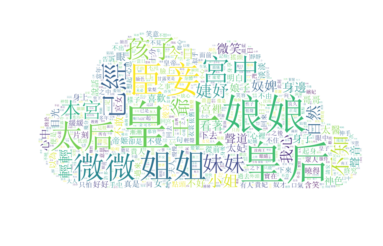

<Figure size 432x288 with 0 Axes>

In [34]:
%matplotlib inline
from PIL import Image

alice_mask = np.array(Image.open("images/cloud_mask7.png"))
wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask, font_path="font/simsun.ttf")
wc.generate_from_frequencies(Counter(terms))

#store to file
picture_name = "images/jieba_07.png"
wc.to_file(picture_name)

# show word cloud
#plt.rcParams["figure.figsize"] = (100,80)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

### 「字」頻度統計結果

jieba_08.py

In [35]:
import os, codecs
from collections import Counter

def get_words(txt):
    seg_list = list(txt)
    # load stopwords set
    stopwordset = set()
    with open('dict/stopwords.txt','r',encoding='utf-8') as sw:
        for line in sw:
            stopwordset.add(line.strip('\n'))
    c = Counter()
    for x in seg_list:
        if len(x)>0 and x != '\r\n' and x not in stopwordset and x !='\r' and x !='\n' and x != '\x1a' and x !='\ufeff':
            c[x] += 1
    print('常用詞頻度統計結果')
    print(dict(c))

if __name__ == '__main__':
    with codecs.open('data/後宮甄嬛傳.txt', 'r', encoding='utf-8') as f:
        txt = f.read()
    get_words(txt)

常用詞頻度統計結果
{'章': 346, ' ': 253, '雲': 671, '意': 3976, '春': 750, '深': 1291, '進': 1481, '宮': 6291, '天': 1961, '非': 657, '晴': 71, '朗': 173, '日': 4284, '子': 8546, '乾': 211, '元': 431, '十': 1347, '年': 2071, '農': 5, '曆': 1, '月': 1978, '黃': 433, '道': 13636, '吉': 100, '站': 336, '紫': 410, '禁': 315, '城': 225, '空': 552, '曠': 26, '院': 248, '落': 1513, '裡': 3885, '無': 3875, '好': 6318, '藍': 212, '澄': 51, '汪': 73, '碧': 1908, '玉': 1821, '絲': 847, '彩': 192, '偶': 222, '爾': 198, '雁': 59, '成': 1242, '群': 86, '結': 352, '隊': 13, '飛': 423, '鴻': 89, '高': 726, '說': 5649, '預': 47, '兆': 39, '毓': 4, '祥': 231, '門': 722, '外': 1466, '整': 389, '排': 140, '列': 62, '數': 641, '專': 115, '送': 650, '秀': 319, '女': 2282, '馬': 342, '車': 169, '人': 9330, '鴉': 57, '雀': 64, '聲': 3902, '保': 460, '持': 268, '異': 296, '沉': 1329, '默': 692, '黑': 243, '壓': 203, '端': 988, '綠': 361, '肥': 16, '紅': 1419, '瘦': 112, '嫩': 78, '臉': 1426, '修': 293, '蛾': 6, '脂': 164, '粉': 378, '香': 1214, '撲': 252, '鼻': 143, '少': 965, '話': 2393, '只': 6165, '心': 8460, '

### 常用詞頻度統計結果

jieba_09.py

In [36]:
import os, codecs
import jieba
from collections import Counter
 
def get_words(txt):
    seg_list = jieba.cut(txt)
    c = Counter()
    stopwordset = set()
    with open('dict/stopwords.txt','r',encoding='utf-8') as sw:
        for line in sw:
            stopwordset.add(line.strip('\n'))
    for x in seg_list:
        if len(x)>0 and x != '\r\n' and x not in stopwordset and x !='\r' and x !='\n':
            c[x] += 1
    print('常用詞頻度統計結果')
    for (k,v) in c.most_common(100):
        print('%s%s %s  %d' % ('  '*(5-len(k)), k, '*'*int(v/3), v))

if __name__ == '__main__':
    with codecs.open('data/後宮甄嬛傳.txt', 'r', encoding='utf-8') as f:
        txt = f.read()
    get_words(txt)


常用詞頻度統計結果
        道 ********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

### word index in dictionary

In [37]:
import os, codecs
from collections import Counter

def get_words(content):
    seg_list = list(content)
    word_index_dict = {}
    tmp_list = []

    # load stopwords set
    stopwordset = set()
    with open('dict/stopwords.txt','r',encoding='utf-8') as sw:
        for line in sw:
            stopwordset.add(line.strip('\n'))
    c = Counter()
    for x in seg_list:
        if len(x)>0 and x != '\r\n' and x not in stopwordset and x !='\r' and x !='\n' and x != '\x1a' and x !='\ufeff' and x !=' ' and x !='○':
            c[x] += 1
    temp_dic = dict(c)
    word_index_dict = {}
    index_word_dict = {}
    for k,v in enumerate(temp_dic):
        index_word_dict[k] = v
        word_index_dict[v] = k
    
    int_word = word_index_dict["宮"]
    # 6
    print(int_word)
    print(index_word_dict[int_word])
    
if __name__ == '__main__':
    with codecs.open('data/後宮甄嬛傳.txt', 'r', encoding='utf-8') as f:
        content = f.read()
    get_words(content)

6
宮


### 建立 jieba 分詞function取得list, 傳入單一句子

jieba_11.py

In [38]:
import os, codecs
import jieba
from collections import Counter

jieba.initialize()

def _david_jieba_cut(text, cut_all):
    punct = set(u''':!),.:;?]}$¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘-—_…''')
    # punct |= set(exception)
    words = [word for word in jieba.cut(text, cut_all=cut_all) if (len(word.strip()) >= 2) and ( not any(ext in word for ext in punct) )]
    return words

def get_words(content):
    seg_list = jieba.cut(content, cut_all=cut_all)
    print(type(seg_list))
    print(" / ".join(seg_list))

    
if __name__ == '__main__':
    content = "我來自成功大學資訊工程系"
    # get_words(content, True)
    print(_david_jieba_cut(content, False))

['來自', '成功', '大學', '資訊', '工程系']


### 建立 jieba 分詞function取得list, 傳入 list

In [39]:
import time
import jieba

jieba.initialize()

In [40]:
input_file_name = "data/後宮甄嬛傳.txt"
with open(input_file_name, 'r', encoding="utf8") as file:
    c_list = file.readlines()
file.close()

res_list = []
t1 = time.time()
for sentense in c_list:
    res_list.append(_david_jieba_cut(sentense, False))
t2 = time.time()
tm_cost = t2-t1
print('time cost: {}'.format(tm_cost))
print('speed %s bytes/second' % (len(content)/tm_cost))

time cost: 15.952941656112671
speed 0.752212366764469 bytes/second


In [41]:
res_list[:1]

[['第一章', '雲意春深']]

### 提升 jieba 效率，多執行緒處理, 變成一大文件

方法一：使用內建的 jieba.enable_parallel()

In [42]:
input_file_name = "data/後宮甄嬛傳.txt"
with open(input_file_name, 'r', encoding="utf8") as file:
    c = file.read()
file.close()

In [43]:
content = c.replace('\u3000\u3000','').replace('\n',' ')

In [44]:
import time
import jieba

jieba.initialize()

# only support posix system, ubuntu, linux etc.
#jieba.enable_parallel()

In [45]:
def _david_jieba_cut(text, cut_all):
    punct = set(u''':!),.:;?]}$¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘-—_…''')
    # punct |= set(exception)
    words = [word for word in jieba.cut(text, cut_all=cut_all) if (len(word.strip()) >= 2) and ( not any(ext in word for ext in punct) )]
    return words

def get_words(content):
    seg_list = jieba.cut(content, cut_all=cut_all)
    print(type(seg_list))
    print(" / ".join(seg_list))

t1 = time.time()
res_list = _david_jieba_cut(content, False)
t2 = time.time()
tm_cost = t2-t1
print('time cost: {}'.format(tm_cost))
print('speed %s bytes/second' % (len(content)/tm_cost))

time cost: 14.757537603378296
speed 102259.81058347675 bytes/second


In [46]:
res_list[:5]

['第一章', '雲意春深', '初進宮', '一天', '非常']

### Windows multiprocessing , 傳入 list

方法二：使用 multiprocessing.dummy on Windows 10

In [47]:
import time
import jieba
import pandas as pd
#from multiprocessing import Pool,cpu_count

jieba.initialize()

input_file_name = "data/後宮甄嬛傳.txt"
with open(input_file_name, 'r', encoding="utf8") as file:
    c_list = file.read().splitlines()
file.close()
c_list[:10]

['\u3000\u3000第一章 雲意春深',
 '',
 '\u3000\u3000我初進宮的那一天，是個非常晴朗的日子。乾元十二年農曆八月二十，黃道吉日。站在紫禁城空曠的院落裡可以看見無比晴好的天空，藍澄澄的如一汪碧玉，沒有一絲雲彩，偶爾有大雁成群結隊地飛過。',
 '',
 '\u3000\u3000鴻雁高飛，據說這是一個非常好的預兆。',
 '',
 '\u3000\u3000毓祥門外整整齊齊地排列著無數專送秀女的馬車，所有的人都鴉雀無聲，保持異常的沉默。我和來自各地的秀女站在一起，黑壓壓一群人，端的是綠肥紅瘦，嫩臉修蛾，脂粉香撲鼻。很少有人說話，只專心照看自己的脂粉衣裳是否周全，或是好奇地偷眼觀察近旁的秀女。',
 '',
 '\u3000\u3000選秀是每個官家少女的命運，每三年一選，經過層層選拔，將才貌雙全的未婚女子選入皇宮，充實後庭。',
 '']

In [48]:
df_ = pd.DataFrame(c_list, columns=['content'])
df_['content'] = df_['content'].str.rstrip('\n')
# df_.shape[0] # 45586
df_ = df_[df_ != '']
df_ = df_.dropna(subset=['content'],inplace=False)
# df_.shape[0] # 22673
df_.head()

,content
0,第一章 雲意春深
2,我初進宮的那一天，是個非常晴朗的日子。乾元十二年農曆八月二十，黃道吉日。站在紫禁城空曠的...
4,鴻雁高飛，據說這是一個非常好的預兆。
6,毓祥門外整整齊齊地排列著無數專送秀女的馬車，所有的人都鴉雀無聲，保持異常的沉默。我和來自...
8,選秀是每個官家少女的命運，每三年一選，經過層層選拔，將才貌雙全的未婚女子選入皇宮，充實後庭。


In [49]:
import multiprocessing.dummy as multiprocessing

cpu_count = 4

def jiebaCut(x):
    return list(jieba.lcut(str(x).strip(),cut_all=False))

t1 = time.time()
with multiprocessing.Pool(processes=(cpu_count)) as pool:
    res_list = pool.map(jiebaCut, df_['content'])
t2 = time.time()
tm_cost = t2-t1
print('time cost: {}'.format(tm_cost))
print('speed %s bytes/second' % (len(content)/tm_cost))

time cost: 10.097547054290771
speed 149452.4355158844 bytes/second


In [50]:
res_list[:1]

[['第一章', ' ', '雲意春深']]

#### 修改function以map取代for

In [51]:
def jiebaCut(x):
    return list(jieba.lcut(str(x).strip(),cut_all=False))

t1 = time.time()
df_['content_jieba'] = list(map(jiebaCut, df_['content']))
t2 = time.time()
tm_cost = t2-t1
print('time cost: {}'.format(tm_cost))
print('speed %s bytes/second' % (len(content)/tm_cost))

time cost: 9.895238876342773
speed 152507.99084880267 bytes/second


In [52]:
df_.head()

,content,content_jieba
0,第一章 雲意春深,"[第一章, , 雲意春深]"
2,我初進宮的那一天，是個非常晴朗的日子。乾元十二年農曆八月二十，黃道吉日。站在紫禁城空曠的...,"[我, 初進宮, 的, 那, 一天, ，, 是, 個, 非常, 晴朗, 的, 日子, 。, ..."
4,鴻雁高飛，據說這是一個非常好的預兆。,"[鴻雁, 高, 飛, ，, 據說, 這是, 一個, 非常, 好, 的, 預兆, 。]"
6,毓祥門外整整齊齊地排列著無數專送秀女的馬車，所有的人都鴉雀無聲，保持異常的沉默。我和來自...,"[毓, 祥, 門外, 整整齊齊, 地, 排列, 著, 無數, 專送, 秀女, 的, 馬車, ..."
8,選秀是每個官家少女的命運，每三年一選，經過層層選拔，將才貌雙全的未婚女子選入皇宮，充實後庭。,"[選秀, 是, 每個, 官家, 少女, 的, 命運, ，, 每, 三年, 一選, ，, 經過..."


利用Pandas.DataFrame與map一比一的進行jieba，與平行處理並行，會得到更加快速的結果。

## Homework

- 尋找自己想要分析的文章、新聞
- 提供詞頻或者字頻
- 建立文字雲進行
- 告訴大家你的發現

<a id="text-processing-models"></a>

## 文句處理，詞袋、N-gram以及TFIDF模型

### 詞袋、TF-IDF 理論知識

兩篇中文文字，如何計算相似度？相似度是數學上的概念，自然語言難以達成，所有要把內文轉化為向量。兩個向量計算相似度就很簡單了，歐式距離、余弦相似度等等各種方法，只需要中學水準的數學知識。那麼如何將文本表示成向量呢？

• 詞袋模型 最簡單的表示方法是詞袋模型。把一篇文本想像成一個個詞構成的，所有詞放入一個袋子裡，沒有先後順序、沒有語義。 例如：

John likes to watch movies. Mary likes too.

John also likes to watch football games.

這兩個句子，可以構建出一個詞典，key為上文出現過的詞，value為這個詞的索引序號 {“John”: 1, “likes”: 2,”to”: 3, “watch”: 4, “movies”: 5,”also”: 6, “football”: 7, “games”: 8,”Mary”: 9, “too”: 10} 那麼，上面兩個句子用詞袋模型表示成向量就是：

[1, 2, 1, 1, 1, 0, 0, 0, 1, 1] [1, 1,1, 1, 0, 1, 1, 1, 0, 0]

相較於英文，中文更複雜一些，涉及到分詞。準確地分詞是所有中文語句分析的基礎，本文使用結巴分詞，與大衛字典。

• TF-IDF模型

詞袋模型簡單易懂，但是存在問題。中文文本裡最常見的詞是“的”、“是”、“有”這樣的沒有實際含義的詞。一篇關於足球的中文文本，“的”出現的數量肯定多於“足球”。所以，要對文本中出現的詞賦予權重。

一個詞的權重由TF * IDF 表示，其中TF表示詞頻，即一個詞在這篇文本中出現的頻率；IDF表示逆文檔頻率，即一個詞在所有文本中出現的頻率倒數。因此，一個詞在某文本中出現的越多，在其他文本中出現的越少，則這個詞能很好地反映這篇文本的內容，權重就越大。

回過頭看詞袋模型，只考慮了文本的詞頻，而TF-IDF模型則包含了詞的權重，更加準確。文本向量與詞袋模型中的維數相同，只是每個詞的對應分量值換成了該詞的TF-IDF值

第一步：計算詞頻TF (Term Frequency)

$$
詞頻(TF) = 某個詞彙在文章中出現的次數
$$

考慮到文章有長短之分，為了便於不同文章的比較，進行"詞頻"標準化。

$$
詞頻標準化(TF) = \frac{某個詞彙在文章中出現的次數}{文章的總詞彙數}
$$

或者

$$
詞頻(TF) = \frac{某個詞彙在文章中出現的次數}{該文出現次數最多的詞彙的出現次數}
$$

第二步：計算IDF逆文檔頻率 (Inverse Document Frequency)
這時，需要一個語料庫（corpus），用來類比語言的使用環境。

$$
逆文檔頻率(IDF) = log\frac{語料庫裡的文件總數}{包含該詞彙的文件數+1}
$$


如果一個詞彙越常見，那麼分母就越大，逆向文件頻率(IDF)就越小越趨近於0。分母之所以要加1，是為了避免分母為0（即所有文檔都不包含該詞）。log表示對得到的值取對數。

第三步：計算TF-IDF

$$
TF-IDF = 詞頻(TF)×逆文檔頻率(IDF)
$$

然而。TF-IDF與一個詞在文字檔中的出現次數成正比，與該詞在整個語言中的出現次數成反比。所以，自動萃取關鍵字的演算法就誕生了，即是計算出文字檔的每個詞的TF-IDF值，然後按降冪排列，取排在最前面的幾個詞。還是以《台灣的蜜蜂養殖》為例，假設該文章長度為1000個詞，"台灣"、"蜜蜂"、"養殖"各出現20次，則這三個詞的"詞頻"（TF）都為0.02。然後，搜索Google發現，包含"的"字的網頁共有250億張，假設這就是中文網頁總數。包含"台灣"的網頁共有62.3億張，包含"蜜蜂"的網頁為0.484億張，包含"養殖"的網頁為0.973億張。則它們的逆文檔頻率（IDF）和TF-IDF如下：

|      | 包含該詞彙的文件數量(億) |IDF|TF-IDF|
|:----:|:----------------------:|||
| 台灣 | 62.30                   |0.603|0.0121|
| 蜜蜂 | 0.484                   |2.713|0.0543|
| 養殖 | 0.973                   |2.410|0.0482|

### TF-IDF 演算法

TF-IDF 演算法包含了兩個部分：詞頻（term frequency，TF）跟逆向文件頻率（inverse document frequency，IDF）。詞頻指的是某一個給定的詞語在該文件中出現的頻率，第 t個詞出現在第 ~d~ 篇文件的頻率記做 ~tf_{t,d}~，舉例來說，如果文件 1 總共有100個字，而第 1 個字在文件 1 出現的次數是12次，因此~tf_{1,1}=12/100~，如此一來，我們就可以針對上述的第一個問題進行修正，以頻率而不是次數來看待文字的重要性，讓文章與文章之間比較有可比較性。

- 詞頻 (term frequency, TF)，指的是某一個給定的詞語在該文件中出現的次數。對於一份文檔而言，詞頻是這個特定詞語在這篇文章中出現的次數除以文檔的詞語總數。

例如：一個文檔中有100個詞，其中『樸素貝葉斯』出現了5次，『的』出現了25次，那麼他們對於的詞頻就是0.05,0.25。這個數字通常會被歸一化(一般是詞頻除以文章總詞數), 以防止它偏向長的文件。（同一個詞語在長文件里可能會比短文件有更高的詞頻，而不管該詞語重要與否。）

但是, 需要注意, 一些通用的詞語對於主題並沒有太大的作用, 反倒是一些出現頻率較少的詞才能夠表達文章的主題, 所以單純使用是TF不合適的。權重的設計必須滿足：一個詞預測主題的能力越強，權重越大，反之，權重越小。所有統計的文章中，一些詞只是在其中很少幾篇文章中出現，那麼這樣的詞對文章的主題的作用很大，這些詞的權重應該設計的較大。IDF就是在完成這樣的工作。


- IDF也叫逆向文件頻率 (inverse document frequency) ，其主要思想是：如果包含詞條t的文件越少, IDF越大，則說明詞條具有很好的類別區分能力。

某一特定詞語的IDF，可以由總文章數目除以包含該詞彙之文件的數目，再將得到的商取對數 log 得到，表達的是詞彙的權重指數

例如：假設我們有一個資料集有 10000 篇文章，其中『樸素貝葉斯』只出現在10篇文章中，則權重指數 idf=log(10000/10)=3。如果一個詞彙在所有的文字檔中都出現，那麼他就沒有可代表性，其 idf=log(1)=0, 這樣可以有效的過濾掉一些詞頻過高的日常用語。

某一特定文件內的高詞語頻率，以及該詞語在整個文件集合中的低文件頻率，可以產生出高權重的TF-IDF。因此，TF-IDF傾向於過濾掉常見的詞語，保留重要的詞語。

- TF-IDF = TF*IDF

有了 tfidf 這個工具，我們就可以把一篇文章、一句話轉化為一個向量。

首先，從資料集中提取所有出現的字詞，我們稱之為詞彙，其次，針對文章中每個詞彙，我們都去計算它的tfidf的值，並把這個值填入文章向量中這個詞彙所對應的元素上。這樣就把一篇文檔轉換成一個向量。

一篇文章往往只會由詞典中小部分詞彙構成，這就意味著這個向量中的大部分元素都是0。

In [53]:
docA = "The cat sat on my face"
docB = "The dog sat on my bed" 

In [54]:
bowA = docA.split(" ")
bowB = docB.split(" ")

In [55]:
bowB

['The', 'dog', 'sat', 'on', 'my', 'bed']

In [56]:
wordSet = set(bowA).union(set(bowB))
wordSet

{'The', 'bed', 'cat', 'dog', 'face', 'my', 'on', 'sat'}

In [57]:
wordDictA = dict.fromkeys(wordSet, 0) 
wordDictB = dict.fromkeys(wordSet, 0)
wordDictA

{'The': 0, 'bed': 0, 'cat': 0, 'dog': 0, 'face': 0, 'my': 0, 'on': 0, 'sat': 0}

In [58]:
for word in bowA:
    wordDictA[word]+=1
    
for word in bowB:
    wordDictB[word]+=1

In [59]:
wordDictA

{'The': 1, 'bed': 0, 'cat': 1, 'dog': 0, 'face': 1, 'my': 1, 'on': 1, 'sat': 1}

In [60]:
import pandas as pd
pd.DataFrame([wordDictA, wordDictB])

,The,bed,cat,dog,face,my,on,sat
0,1,0,1,0,1,1,1,1
1,1,1,0,1,0,1,1,1


In [61]:
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

In [62]:
tfBowA = computeTF(wordDictA, bowA)
tfBowB = computeTF(wordDictB, bowB)
tfBowA

{'The': 0.16666666666666666,
 'bed': 0.0,
 'cat': 0.16666666666666666,
 'dog': 0.0,
 'face': 0.16666666666666666,
 'my': 0.16666666666666666,
 'on': 0.16666666666666666,
 'sat': 0.16666666666666666}

In [63]:
tfBowB

{'The': 0.16666666666666666,
 'bed': 0.16666666666666666,
 'cat': 0.0,
 'dog': 0.16666666666666666,
 'face': 0.0,
 'my': 0.16666666666666666,
 'on': 0.16666666666666666,
 'sat': 0.16666666666666666}

In [64]:
def computeIDF(docList):
    import math
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict  

In [65]:
idfs = computeIDF([wordDictA, wordDictB])
idfs

{'The': 0.0,
 'bed': 0.3010299956639812,
 'cat': 0.3010299956639812,
 'dog': 0.3010299956639812,
 'face': 0.3010299956639812,
 'my': 0.0,
 'on': 0.0,
 'sat': 0.0}

In [66]:
def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [67]:
tfidfBowA = computeTFIDF(tfBowA, idfs)
tfidfBowB = computeTFIDF(tfBowB, idfs)

In [68]:
import pandas as pd
pd.DataFrame([tfidfBowA, tfidfBowB])

,The,bed,cat,dog,face,my,on,sat
0,0.0,0.000000,0.050172,0.000000,0.050172,0.0,0.0,0.0
1,0.0,0.050172,0.000000,0.050172,0.000000,0.0,0.0,0.0


#### 使用 Python sklearn 實現 TF-IDF 演算法

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
# docA = "The car is driven on the road"
# docB = "The truck is driven on the highway" 
docA = "The cat sat on my face"
docB = "The dog sat on my bed"

In [71]:
tfidf = TfidfVectorizer()

In [72]:
response = tfidf.fit_transform([docA, docB])
response

<2x8 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [73]:
feature_names = tfidf.get_feature_names()
list_feature = []
list_tfidf = []
for col in response.nonzero()[1]:
    print(feature_names[col], ' - ', response[0, col])
    list_feature.append(feature_names[col])
    list_tfidf.append(response[0, col])

face  -  0.49844627974580596
my  -  0.35464863330313684
on  -  0.35464863330313684
sat  -  0.35464863330313684
cat  -  0.49844627974580596
the  -  0.35464863330313684
bed  -  0.0
dog  -  0.0
my  -  0.35464863330313684
on  -  0.35464863330313684
sat  -  0.35464863330313684
the  -  0.35464863330313684


In [74]:
pd.DataFrame([list_feature, list_tfidf])

,0,1,2,3,4,5,6,7,8,9,10,11
0,face,my,on,sat,cat,the,bed,dog,my,on,sat,the
1,0.49844627974580596,0.35464863330313684,0.35464863330313684,0.35464863330313684,0.49844627974580596,0.35464863330313684,0.0,0.0,0.35464863330313684,0.35464863330313684,0.35464863330313684,0.35464863330313684


### Simple text pre-processing, 文字預處理

In [75]:
import os, codecs
import jieba
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

def simple_cht_word_cut(text):
    exception = []
    punct = set(u''':!),.:;?]}$¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘-—_…''')
    punct |= set(exception)
    words = [word for word in jieba.cut(text, cut_all=True) if (len(word.strip()) >= 2) and ( not any(ext in word for ext in punct) )]
    return " ".join(words)

def normalize_document(text, stopwords, exception):
    punct = set(u''':!),.:;?]}$¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘-—_…''')
    punct |= set(exception)
    words = [word for word in jieba.cut(text, cut_all=True) if (len(word.strip()) >= 2) and (word not in stopwords) and ( not any(ext in word for ext in punct) )]
    return " ".join(words)

In [76]:
test_str = '據悉，連千毅2018年的營收就超過幾十億台幣，且這還是他個人的銷售成績，他在高雄的總部宛如名牌精品店，公司有好幾層樓，還有其中一層是全部都擺著名錶的展示櫃，可說是金碧輝煌，且旗下養的小弟都住在公司樓上的宿舍，還有號稱全台歌曲最新的KTV大廳，常有政商名流來他的公司喝酒泡茶搏感情。'
r = simple_cht_word_cut(test_str)
r

'據悉 2018 超過 幾十 幾十億 十億 億台 台幣 還是 個人 銷售 成績 高雄 總部 宛如 名牌 精品 精品店 公司 好幾 好幾層 幾層 幾層樓 層樓 還有 其中 全部 著名 展示 展示櫃 可說 可說是 金碧 金碧輝煌 輝煌 旗下 小弟 公司 樓上 宿舍 還有 號稱 全台 歌曲 最新 KTV 大廳 常有 政商 名流 流來 公司 喝酒 泡茶 感情'

In [77]:
corpus = ['天空蔚藍美麗。',
          '愛上這藍色美麗的天空！',
          '敏捷的棕色狐狸跳過了懶狗。',
          "國王的早餐包括香腸，火腿，培根，雞蛋，吐司和豆類。",
          '我喜歡吃雞蛋，火腿，香腸與培根！',
          '棕色的狐狸跑很快，而藍色的狗狗很懶！',
          '今天的天空好藍，溫度適中',
          '狗狗很懶，但是棕狐很快！'
]
labels = ['天氣', '天氣', '動物', '食物', '食物', '動物', '天氣', '動物']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,天空蔚藍美麗。,天氣
1,愛上這藍色美麗的天空！,天氣
2,敏捷的棕色狐狸跳過了懶狗。,動物
3,國王的早餐包括香腸，火腿，培根，雞蛋，吐司和豆類。,食物
4,我喜歡吃雞蛋，火腿，香腸與培根！,食物
5,棕色的狐狸跑很快，而藍色的狗狗很懶！,動物
6,今天的天空好藍，溫度適中,天氣
7,狗狗很懶，但是棕狐很快！,動物


In [78]:
stopwords = set()
with open('dict/stopwords.txt', 'r', encoding="utf8") as file:
    stopwords = file.readlines()
    stopwords = [stopword.strip('\n').strip() for stopword in stopwords]
except_file = open("dict/hippo_exception_word.txt", encoding='utf-8')
exception = except_file.read().split(',')
exception.append(" ")

x_document = list(corpus_df["Document"])
norm_corpus = []
for x in tqdm(x_document):
    norm_corpus.append(normalize_document(x, stopwords, exception))

norm_corpus = np.asarray(norm_corpus)
norm_corpus

100%|████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2304.56it/s]


array(['天空 蔚藍 美麗', '藍色 美麗 天空', '敏捷 棕色 狐狸', '國王 早餐 包括 香腸 火腿 培根 雞蛋 吐司 豆類',
       '喜歡 雞蛋 火腿 香腸 培根', '棕色 狐狸 很快 藍色 狗狗', '天空 溫度 適中', '狗狗 很快'],
      dtype='<U26')

### Bag of Words Model 詞袋

In [79]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
# 將 norm_corpus 轉置為 CountVectorizer 矩陣
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [80]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
df_ = pd.DataFrame(cv_matrix, columns=vocab)
df_

,包括,吐司,喜歡,國王,培根,天空,很快,敏捷,早餐,棕色,...,火腿,狐狸,狗狗,美麗,蔚藍,藍色,豆類,適中,雞蛋,香腸
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,1,0,1,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,1
4,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
5,0,0,0,0,0,0,1,0,0,1,...,0,1,1,0,0,1,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [81]:
subset = corpus_df.loc[[1,2]]
subset

,Document,Category
1,愛上這藍色美麗的天空！,天氣
2,敏捷的棕色狐狸跳過了懶狗。,動物


In [82]:
subset = df_.loc[ [1, 2] ,['今天','包括','吐司','培根','天空','很快','敏捷','早餐','棕色','火腿','狐狸','狗狗'] ]
subset

D:\Anaconda36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,今天,包括,吐司,培根,天空,很快,敏捷,早餐,棕色,火腿,狐狸,狗狗
1,NaN,0,0,0,1,0,0,0,0,0,0,0
2,NaN,0,0,0,0,0,1,0,1,0,1,0


### Bag of N-Grams Model

In [83]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
df_ = pd.DataFrame(bv_matrix, columns=vocab)
df_

,包括 香腸,吐司 豆類,喜歡 雞蛋,國王 早餐,培根 雞蛋,天空 溫度,天空 蔚藍,很快 藍色,敏捷 棕色,早餐 包括,...,狐狸 很快,狗狗 很快,美麗 天空,蔚藍 美麗,藍色 狗狗,藍色 美麗,雞蛋 吐司,雞蛋 火腿,香腸 培根,香腸 火腿
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### TF-IDF Model

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
df_ = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
df_

,包括,吐司,喜歡,國王,培根,天空,很快,敏捷,早餐,棕色,...,火腿,狐狸,狗狗,美麗,蔚藍,藍色,豆類,適中,雞蛋,香腸
0,0.00,0.00,0.00,0.00,0.00,0.48,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.56,0.67,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.52,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.60,0.00,0.60,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.54,...,0.00,0.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.36,0.36,0.00,0.36,0.30,0.00,0.00,0.00,0.36,0.00,...,0.30,0.00,0.00,0.00,0.00,0.00,0.36,0.00,0.30,0.30
4,0.00,0.00,0.51,0.00,0.43,0.00,0.00,0.00,0.00,0.00,...,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.43
5,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.45,...,0.00,0.45,0.45,0.00,0.00,0.45,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.46,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.63,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.00,0.00,0.00,...,0.00,0.00,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Document Similarity

In [85]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7
0,1.000000,0.591620,0.000000,0.00000,0.00000,0.000000,0.220722,0.000000
1,0.591620,1.000000,0.000000,0.00000,0.00000,0.269944,0.237150,0.000000
2,0.000000,0.000000,1.000000,0.00000,0.00000,0.483387,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.00000,0.51509,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.51509,1.00000,0.000000,0.000000,0.000000
5,0.000000,0.269944,0.483387,0.00000,0.00000,1.000000,0.000000,0.632456
6,0.220722,0.237150,0.000000,0.00000,0.00000,0.000000,1.000000,0.000000
7,0.000000,0.000000,0.000000,0.00000,0.00000,0.632456,0.000000,1.000000


### Clustering documents using similarity features

In [86]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 
                         'Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,0,1,0.63772,2
1,3,4,0.685766,2
2,5,7,0.759414,2
3,6,8,1.29388,3
4,2,10,1.35167,3
5,9,11,2.26021,5
6,12,13,2.32449,8


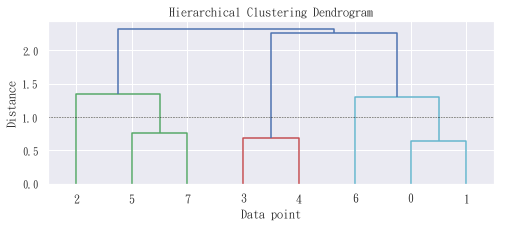

In [87]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

### Convert cluster label into numeric

In [88]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_ = pd.concat([corpus_df, cluster_labels], axis=1)
df_

,Document,Category,ClusterLabel
0,天空蔚藍美麗。,天氣,4
1,愛上這藍色美麗的天空！,天氣,4
2,敏捷的棕色狐狸跳過了懶狗。,動物,2
3,國王的早餐包括香腸，火腿，培根，雞蛋，吐司和豆類。,食物,3
4,我喜歡吃雞蛋，火腿，香腸與培根！,食物,3
5,棕色的狐狸跑很快，而藍色的狗狗很懶！,動物,1
6,今天的天空好藍，溫度適中,天氣,5
7,狗狗很懶，但是棕狐很快！,動物,1


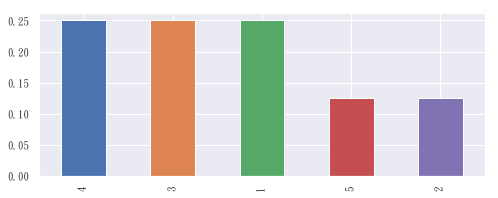

In [89]:
# ClusterLabel 1 is more than others (but there are total 3 cat.)
df_.ClusterLabel.value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(8, 3))

<a id="TopicModels"></a>

## Topic Models

In [90]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3, max_iter=10000, random_state=0)
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
features

,T1,T2,T3
0,0.832747,0.083594,0.083659
1,0.828585,0.083595,0.087820
2,0.083738,0.083638,0.832624
3,0.033564,0.932886,0.033550
4,0.055848,0.888322,0.055830
5,0.057479,0.055732,0.886789
6,0.832570,0.083673,0.083757
7,0.111516,0.111414,0.777070


### Show topics and their weights

In [91]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.3] # 參數可調，若要更精確，調成0.6，但會有outlier
    print("-"*10)
    print(topic)
    print("-"*10)

----------
[('天空', 3.332073777917568), ('美麗', 2.3320242617163096), ('蔚藍', 1.3320151847363826), ('溫度', 1.332010076816362), ('適中', 1.332010076816362), ('藍色', 1.3260928654327564), ('很快', 0.33419121687940834), ('狗狗', 0.33419121687940834), ('敏捷', 0.3341671948048822), ('棕色', 0.3339815283585271), ('狐狸', 0.3339815283585271), ('喜歡', 0.33394158847416955), ('培根', 0.3337781163364651), ('火腿', 0.3337781163364651), ('雞蛋', 0.3337781163364651), ('香腸', 0.3337781163364651), ('包括', 0.3336674074911685), ('吐司', 0.3336674074911685), ('國王', 0.3336674074911685), ('早餐', 0.3336674074911685), ('豆類', 0.3336674074911685)]
----------
----------
[('培根', 2.332471685802134), ('火腿', 2.332471685802134), ('雞蛋', 2.332471685802134), ('香腸', 2.332471685802134), ('包括', 1.3326862076763888), ('吐司', 1.3326862076763888), ('國王', 1.3326862076763888), ('早餐', 1.3326862076763888), ('豆類', 1.3326862076763888), ('喜歡', 1.3321549859458477), ('藍色', 0.33428278854229104), ('很快', 0.33396016824763775), ('狗狗', 0.33396016824763775), ('敏捷', 0.33395

### Clustering documents using topic model features

In [92]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(features)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
df_ = pd.concat([corpus_df, cluster_labels], axis=1)
df_

,Document,Category,ClusterLabel
0,天空蔚藍美麗。,天氣,2
1,愛上這藍色美麗的天空！,天氣,2
2,敏捷的棕色狐狸跳過了懶狗。,動物,1
3,國王的早餐包括香腸，火腿，培根，雞蛋，吐司和豆類。,食物,0
4,我喜歡吃雞蛋，火腿，香腸與培根！,食物,0
5,棕色的狐狸跑很快，而藍色的狗狗很懶！,動物,1
6,今天的天空好藍，溫度適中,天氣,2
7,狗狗很懶，但是棕狐很快！,動物,1


In [93]:
### CountVectorizer,TfidfTransformer

In [94]:
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [95]:
import os, codecs
import jieba
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

def normalize_document(text, stopwords, exception):
    punct = set(u''':!),.:;?]}$¢'"、。〉》」』】〕〗〞︰︱︳﹐､﹒﹔﹕﹖﹗﹚﹜﹞！），．：；？｜｝︴︶︸︺︼︾﹀﹂﹄﹏､～￠々‖•·ˇˉ―--′’”([{£¥'"‵〈《「『【〔〖（［｛￡￥〝︵︷︹︻︽︿﹁﹃﹙﹛﹝（｛“‘-—_…''')
    punct |= set(exception)
    words = [word for word in jieba.cut(text, cut_all=True) if (len(word.strip()) >= 2) and (word not in stopwords) and ( not any(ext in word for ext in punct) )]
    return " ".join(words)

In [96]:
post_body = '新加坡環球影城萬首次與泰國知名鬼片《鬼影》和《鬼4虐》導演合作打造原創鬼屋，帶遊客直闖靈魂最深恐懼。娜迦的詛咒鬼屋場景逼真、驚悚特效和原創人物營造滿滿恐怖氣氛，將遊客送往蛇靈娜迦詛咒的失落村莊。膽大的人可以購買日間入場門票以及幕後導覽之旅體驗，揭開娜迦的詛咒幕後恐怖秘密。萬聖節來到新加坡環球影城絕對要去朝聖期間限定的鬼怪遊行，遊客可前往好萊塢潘太及斯劇院觀賞萬聖節娛樂LIVE現場表演，或者加入「敢死音樂節」隨著死亡陷阱樂隊音樂盡情搖擺。另外，在高峰主題夜死亡陷阱樂隊將搭乘花車環繞園區遊行。'
corpus_list = post_body.split('。')
corpus_list = list(filter(None, corpus_list))
corpus_list

['新加坡環球影城萬首次與泰國知名鬼片《鬼影》和《鬼4虐》導演合作打造原創鬼屋，帶遊客直闖靈魂最深恐懼',
 '娜迦的詛咒鬼屋場景逼真、驚悚特效和原創人物營造滿滿恐怖氣氛，將遊客送往蛇靈娜迦詛咒的失落村莊',
 '膽大的人可以購買日間入場門票以及幕後導覽之旅體驗，揭開娜迦的詛咒幕後恐怖秘密',
 '萬聖節來到新加坡環球影城絕對要去朝聖期間限定的鬼怪遊行，遊客可前往好萊塢潘太及斯劇院觀賞萬聖節娛樂LIVE現場表演，或者加入「敢死音樂節」隨著死亡陷阱樂隊音樂盡情搖擺',
 '另外，在高峰主題夜死亡陷阱樂隊將搭乘花車環繞園區遊行']

In [97]:
stopwords_ = set()
with open('dict/stopwords.txt', 'r', encoding="utf8") as file:
    stopwords_ = file.readlines()
    stopwords_ = [stopword.strip('\n').strip() for stopword in stopwords_]
except_file = open("dict/hippo_exception_word.txt", encoding='utf-8')
exception_ = except_file.read().split(',')
exception_.append(" ")

norm_corpus_ = []
for x in tqdm(corpus_list):
    norm_corpus_.append(normalize_document(x, stopwords_, exception_))

norm_corpus_

100%|████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1000.50it/s]


['新加坡 環球 影城 萬首 首次 泰國 知名 鬼片 鬼影 導演 合作 打造 原創 鬼屋 遊客 直闖 靈魂 最深 深恐 恐懼',
 '詛咒 鬼屋 場景 逼真 驚悚 特效 原創 人物 營造 滿滿 恐怖 氣氛 遊客 送往 詛咒 失落 村莊',
 '膽大 購買 日間 入場 門票 幕後 導覽 體驗 揭開 詛咒 幕後 恐怖 秘密',
 '萬聖 萬聖節 來到 新加坡 環球 影城 朝聖 期間 限定 鬼怪 遊行 遊客 前往 好萊塢 劇院 觀賞 萬聖 萬聖節 娛樂 LIVE 現場 現場表演 表演 加入 敢死 音樂 音樂節 死亡 陷阱 樂隊 音樂 盡情 搖擺',
 '高峰 主題 死亡 陷阱 樂隊 搭乘 花車 環繞 園區 遊行']

In [98]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [99]:
text1 = norm_corpus_[:3]
countvect = CountVectorizer()
vt = countvect.fit_transform(text1) #將文章，每一句話 jieba分詞之後的 list 轉換成一個頻數的矩陣

tfidf = TfidfTransformer()
tf = tfidf.fit_transform(vt) #將頻數矩陣轉換為正規化的tf-idf矩陣

bows = countvect.get_feature_names() #詞袋(Bag of Words)
print(bows)

weight = tf.toarray() #轉化成陣列的型別
df3 = pd.DataFrame(weight, columns=bows)
df3

['人物', '入場', '原創', '合作', '場景', '失落', '導演', '導覽', '幕後', '影城', '恐怖', '恐懼', '打造', '揭開', '新加坡', '日間', '最深', '村莊', '氣氛', '泰國', '深恐', '滿滿', '營造', '特效', '環球', '直闖', '知名', '秘密', '膽大', '萬首', '詛咒', '購買', '送往', '逼真', '遊客', '門票', '靈魂', '首次', '驚悚', '體驗', '鬼屋', '鬼影', '鬼片']


,人物,入場,原創,合作,場景,失落,導演,導覽,幕後,影城,...,逼真,遊客,門票,靈魂,首次,驚悚,體驗,鬼屋,鬼影,鬼片
0,0.000000,0.000000,0.175705,0.231031,0.000000,0.000000,0.231031,0.000000,0.000000,0.231031,...,0.000000,0.175705,0.000000,0.231031,0.231031,0.000000,0.000000,0.175705,0.231031,0.231031
1,0.252964,0.000000,0.192386,0.000000,0.252964,0.252964,0.000000,0.000000,0.000000,0.000000,...,0.252964,0.192386,0.000000,0.000000,0.000000,0.252964,0.000000,0.192386,0.000000,0.000000
2,0.000000,0.265777,0.000000,0.000000,0.000000,0.000000,0.000000,0.265777,0.531554,0.000000,...,0.000000,0.000000,0.265777,0.000000,0.000000,0.000000,0.265777,0.000000,0.000000,0.000000


In [100]:
text2 = norm_corpus_[3:]
text2

['萬聖 萬聖節 來到 新加坡 環球 影城 朝聖 期間 限定 鬼怪 遊行 遊客 前往 好萊塢 劇院 觀賞 萬聖 萬聖節 娛樂 LIVE 現場 現場表演 表演 加入 敢死 音樂 音樂節 死亡 陷阱 樂隊 音樂 盡情 搖擺',
 '高峰 主題 死亡 陷阱 樂隊 搭乘 花車 環繞 園區 遊行']

In [101]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [102]:
tfidf = TfidfVectorizer()
tf=tfidf.fit_transform(text1) #將頻數矩陣轉換為正規化的tf-idf矩陣
tf2=tfidf.transform(text2)
word = countvect.get_feature_names() #詞袋
weight1=tf.toarray() #轉成陣列的型別
weight2=tf2.toarray() #轉成陣列的型別
df4=pd.DataFrame(weight,columns=word)
df4

,人物,入場,原創,合作,場景,失落,導演,導覽,幕後,影城,...,逼真,遊客,門票,靈魂,首次,驚悚,體驗,鬼屋,鬼影,鬼片
0,0.000000,0.000000,0.175705,0.231031,0.000000,0.000000,0.231031,0.000000,0.000000,0.231031,...,0.000000,0.175705,0.000000,0.231031,0.231031,0.000000,0.000000,0.175705,0.231031,0.231031
1,0.252964,0.000000,0.192386,0.000000,0.252964,0.252964,0.000000,0.000000,0.000000,0.000000,...,0.252964,0.192386,0.000000,0.000000,0.000000,0.252964,0.000000,0.192386,0.000000,0.000000
2,0.000000,0.265777,0.000000,0.000000,0.000000,0.000000,0.000000,0.265777,0.531554,0.000000,...,0.000000,0.000000,0.265777,0.000000,0.000000,0.000000,0.265777,0.000000,0.000000,0.000000


In [103]:
df5=pd.DataFrame(weight2,columns=word)
df5

,人物,入場,原創,合作,場景,失落,導演,導覽,幕後,影城,...,逼真,遊客,門票,靈魂,首次,驚悚,體驗,鬼屋,鬼影,鬼片
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528635,...,0.0,0.40204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### jieba - TF-IDF

In [104]:
import jieba.analyse
sentence = ' '.join(text2)
print(sentence)
list_feature = []
list_tfidf = []
for x, w in jieba.analyse.extract_tags(sentence, withWeight=True):
    print('%s %s' % (x, w))
    list_feature.append(x)
    list_tfidf.append(w)

萬聖 萬聖節 來到 新加坡 環球 影城 朝聖 期間 限定 鬼怪 遊行 遊客 前往 好萊塢 劇院 觀賞 萬聖 萬聖節 娛樂 LIVE 現場 現場表演 表演 加入 敢死 音樂 音樂節 死亡 陷阱 樂隊 音樂 盡情 搖擺 高峰 主題 死亡 陷阱 樂隊 搭乘 花車 環繞 園區 遊行
萬聖 0.5560356978093023
萬聖節 0.5560356978093023
遊行 0.5560356978093023
音樂 0.5560356978093023
樂隊 0.5560356978093023
陷阱 0.3810961575455814
死亡 0.2909432536069767
來到 0.27801784890465114
環球 0.27801784890465114
朝聖 0.27801784890465114
期間 0.27801784890465114
遊客 0.27801784890465114
好萊塢 0.27801784890465114
劇院 0.27801784890465114
觀賞 0.27801784890465114
娛樂 0.27801784890465114
LIVE 0.27801784890465114
現場 0.27801784890465114
現場表演 0.27801784890465114
音樂節 0.27801784890465114


In [105]:
# 比較自己計算的TF-IDF與jieba的extract_tags
df5.loc[0]

人物     0.000000
入場     0.000000
原創     0.000000
合作     0.000000
場景     0.000000
失落     0.000000
導演     0.000000
導覽     0.000000
幕後     0.000000
影城     0.528635
恐怖     0.000000
恐懼     0.000000
打造     0.000000
揭開     0.000000
新加坡    0.528635
日間     0.000000
最深     0.000000
村莊     0.000000
氣氛     0.000000
泰國     0.000000
深恐     0.000000
滿滿     0.000000
營造     0.000000
特效     0.000000
環球     0.528635
直闖     0.000000
知名     0.000000
秘密     0.000000
膽大     0.000000
萬首     0.000000
詛咒     0.000000
購買     0.000000
送往     0.000000
逼真     0.000000
遊客     0.402040
門票     0.000000
靈魂     0.000000
首次     0.000000
驚悚     0.000000
體驗     0.000000
鬼屋     0.000000
鬼影     0.000000
鬼片     0.000000
Name: 0, dtype: float64

In [106]:
pd.DataFrame([list_feature, list_tfidf])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,萬聖,萬聖節,遊行,音樂,樂隊,陷阱,死亡,來到,環球,朝聖,期間,遊客,好萊塢,劇院,觀賞,娛樂,LIVE,現場,現場表演,音樂節
1,0.556036,0.556036,0.556036,0.556036,0.556036,0.381096,0.290943,0.278018,0.278018,0.278018,0.278018,0.278018,0.278018,0.278018,0.278018,0.278018,0.278018,0.278018,0.278018,0.278018


### Homework
- 尋找自己感興趣的小說，長篇文章，進行訓練
- 利用 jieba的extract_tags 找出標籤
- 你的文章資料分析與發現?